Step 1: Install Necessary Libraries

In [1]:
%pip install pandas
%pip install autogluon
%pip install ipython
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.1.post1
    Uninstalling scikit-learn-1.4.1.post1:
      Successfully uninstalled scikit-learn-1.4.1.post1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
auto-sklearn 0.15.0 requires scikit-learn<0.25.0,>=0.24.0, but you have scikit-learn 1.2.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use u

In [2]:
from psmiles import PolymerSmiles as PS
import pandas as pd
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor

# Read csv and filter EGC
egc_df = pd.read_csv("../recources/export.csv")
egc_df = egc_df[egc_df.property == "Egc"]



### Step 3: Generating Fingerprints from SMILES Strings

In [3]:
#creating fingerprints for SS
smile_string_list = list(egc_df.smiles.values)
value_list = list(egc_df.value.values)
finger_print_list = []
for smile_string in smile_string_list:
    curren_polymere = PS(smile_string)
    finger_print_list.append(curren_polymere.fingerprint())


fp_list_formatted = []
for i in finger_print_list:
    fp_list_formatted.append(i.tolist())
    
print(len(fp_list_formatted[0]))
ss_fp_egc_df = pd.DataFrame({'Smile': smile_string_list, 'Finger_prints': fp_list_formatted, 'Egc': value_list})
print(ss_fp_egc_df)



final_df = pd.DataFrame(
    np.array(finger_print_list), index=smile_string_list
)

ss = pd.Series(value_list, index=smile_string_list, name="Egc")

concatenated_df = pd.concat(
    [final_df, ss],
    axis=1,
).reset_index(names="psmiles")
print(concatenated_df.set_index("psmiles").columns)



auto_ml_df = concatenated_df.sample(frac=1, random_state=0)#shulles the df
print(auto_ml_df.shape)


psmlies_column = auto_ml_df["psmiles"]
auto_ml_df = auto_ml_df.drop(columns=["psmiles"])
auto_ml_df.reset_index(drop=True, inplace=True)
print(auto_ml_df.shape)

2048
                                                 Smile  \
0                                              [*]C[*]   
1                                          [*]CC([*])C   
2                                         [*]CC([*])CC   
3                                        [*]CC([*])CCC   
4                                     [*]CC([*])CC(C)C   
...                                                ...   
3375           [*]Nc1c([2H])c([2H])c([*])c([2H])c1[2H]   
3376               [*]CCCCCC[N+](C)(C)CCC[N+]([*])(C)C   
3377          [*]CCCCCCCC[N+](C)(C)CCCCCC[N+]([*])(C)C   
3378  [*]CCCCCCCCCCCCCCCC[N+](C)(C)CCCCCC[N+]([*])(C)C   
3379       [*]C=Cc1cc([Si](C)(C)C)c([*])cc1[Si](C)(C)C   

                                          Finger_prints     Egc  
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  6.8972  
1     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  6.5196  
2     [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  6.5170  
3     [0, 1, 0, 0, 0, 0, 0, 0, 0, 

### Step 4: Split the Dataset into Training and Testing Sets

In [4]:
split_index = int(len(auto_ml_df) * 0.8)

train_df = auto_ml_df[:split_index]
test_df = auto_ml_df[split_index:]
# evtl min max scaler 

test_df.head()

X_train = train_df.to_numpy()[:, :-1]
y_train = train_df.to_numpy()[:, -1]

X_test = test_df.to_numpy()[:, :-1] 
y_test = test_df.to_numpy()[:, -1]

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((2704, 2048), (2704,)), ((676, 2048), (676,)))

In [5]:
%pip install autogluon
%pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.4.1.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.20.0 requires scikit-learn<1.3.0,>=0.24.0, but you have scikit-learn 1.4.1.post1 which is incompatible.
autogluon-tabular 0.8.2 requires scikit-learn<1.3,>=1.0, but you have scikit-learn 1.4.1.post1 which is incompatible.
autogluon-multimodal 0.8.2 requires scikit-learn<1.3,>=1.0, but you have scikit-learn 1

### Step 5 Train the Model

In [6]:

label = "Egc"
test_df[label].describe()
test_data = train_df
predictor = TabularPredictor(label=label).fit(train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20240406_163502/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240406_163502/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #107-Ubuntu SMP Wed Feb 7 13:26:48 UTC 2024
Disk Space Avail:   2818.90 GB / 7619.64 GB (37.0%)
Train Data Rows:    2704
Train Data Columns: 2048


Label Column: Egc
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (9.8627, 0.0205, 4.53103, 1.56862)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1044468.58 MB
	Train Data (Original)  Memory Usage: 44.3 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 344 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatur

[1000]	valid_set's rmse: 0.608344


	-0.6064	 = Validation score   (-root_mean_squared_error)
	11.51s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.579378


	-0.5789	 = Validation score   (-root_mean_squared_error)
	11.33s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ...
		cannot import name '_fit_context' from 'sklearn.base' (/home/ibrahim/.local/lib/python3.10/site-packages/sklearn/base.py)
Fitting model: CatBoost ...
	-0.5985	 = Validation score   (-root_mean_squared_error)
	74.68s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
		cannot import name '_fit_context' from 'sklearn.base' (/home/ibrahim/.local/lib/python3.10/site-packages/sklearn/base.py)
Fitting model: NeuralNetFastAI ...
		cannot import name '_fit_context' from 'sklearn.base' (/home/ibrahim/.local/lib/python3.10/site-packages/sklearn/base.py)
Fitting model: XGBoost ...
	-0.6034	 = Validation score   (-root_mean_squared_error)
	3.11s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.74	 = Validation score   (-root_mean_squared_error)
	29.43s	 = Training   runtime


In [7]:
print(predictor.get_model_best())
predictor.evaluate(train_df, silent=True)
predictor.evaluate(test_df)

WeightedEnsemble_L2


Evaluation: root_mean_squared_error on test data: -0.5448502218632079
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.5448502218632079,
    "mean_squared_error": -0.2968617642643868,
    "mean_absolute_error": -0.34747997842512185,
    "r2": 0.8749523577574361,
    "pearsonr": 0.9361762191433102,
    "median_absolute_error": -0.23875393486022944
}


{'root_mean_squared_error': -0.5448502218632079,
 'mean_squared_error': -0.2968617642643868,
 'mean_absolute_error': -0.34747997842512185,
 'r2': 0.8749523577574361,
 'pearsonr': 0.9361762191433102,
 'median_absolute_error': -0.23875393486022944}

In [43]:
y_pred = predictor.predict(test_df.drop(columns=[label]))
y_pred.head()

2704    4.704606
2705    5.673189
2706    2.950582
2707    5.720649
2708    5.410748
Name: Egc, dtype: float32

In [29]:
print(test_df)

      0  1  2  3  4  5  6  7  8  9  ...  2039  2040  2041  2042  2043  2044  \
2704  0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2705  0  0  0  0  0  0  0  0  0  4  ...     0     0     0     0     0     0   
2706  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2707  0  0  0  0  0  0  0  0  0  4  ...     0     0     0     0     0     0   
2708  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
...  .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
3375  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3376  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3377  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3378  0  1  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3379  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

      2045  2046  2047     Egc  
2704     0     0  

In [41]:
from IPython.display import display
model_leaderboard = predictor.leaderboard(test_df, silent=True)
display(model_leaderboard)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.544850,-0.553496,0.563726,0.388537,138.123790,0.005098,0.000615,0.150012,2,True,9
1,LightGBM,-0.556867,-0.578900,0.027433,0.019109,11.326932,0.027433,0.019109,11.326932,1,True,4
2,LightGBMLarge,-0.572938,-0.579516,0.029877,0.018734,36.990569,0.029877,0.018734,36.990569,1,True,8
3,CatBoost,-0.582494,-0.598477,0.379609,0.242481,74.675882,0.379609,0.242481,74.675882,1,True,5
4,XGBoost,-0.591429,-0.603357,0.056526,0.041716,3.108911,0.056526,0.041716,3.108911,1,True,6
5,LightGBMXT,-0.592647,-0.606440,0.027785,0.020738,11.511267,0.027785,0.020738,11.511267,1,True,3
6,NeuralNetTorch,-0.660114,-0.739960,0.593066,0.562337,29.431844,0.593066,0.562337,29.431844,1,True,7
7,KNeighborsDist,-0.778787,-0.797117,0.037398,0.045144,0.360216,0.037398,0.045144,0.360216,1,True,2
8,KNeighborsUnif,-0.795133,-0.804697,0.481274,0.556173,0.285731,0.481274,0.556173,0.285731,1,True,1


In [42]:
models = model_leaderboard.model.to_list()
models

['WeightedEnsemble_L2',
 'LightGBM',
 'LightGBMLarge',
 'CatBoost',
 'XGBoost',
 'LightGBMXT',
 'NeuralNetTorch',
 'KNeighborsDist',
 'KNeighborsUnif']

In [35]:
print(y_pred)

0       4.237586
1       5.359901
2       6.458356
3       3.220262
4       5.333035
          ...   
2699    5.840798
2700    2.413163
2701    5.052110
2702    3.371002
2703    3.047493
Name: Egc, Length: 2704, dtype: float32


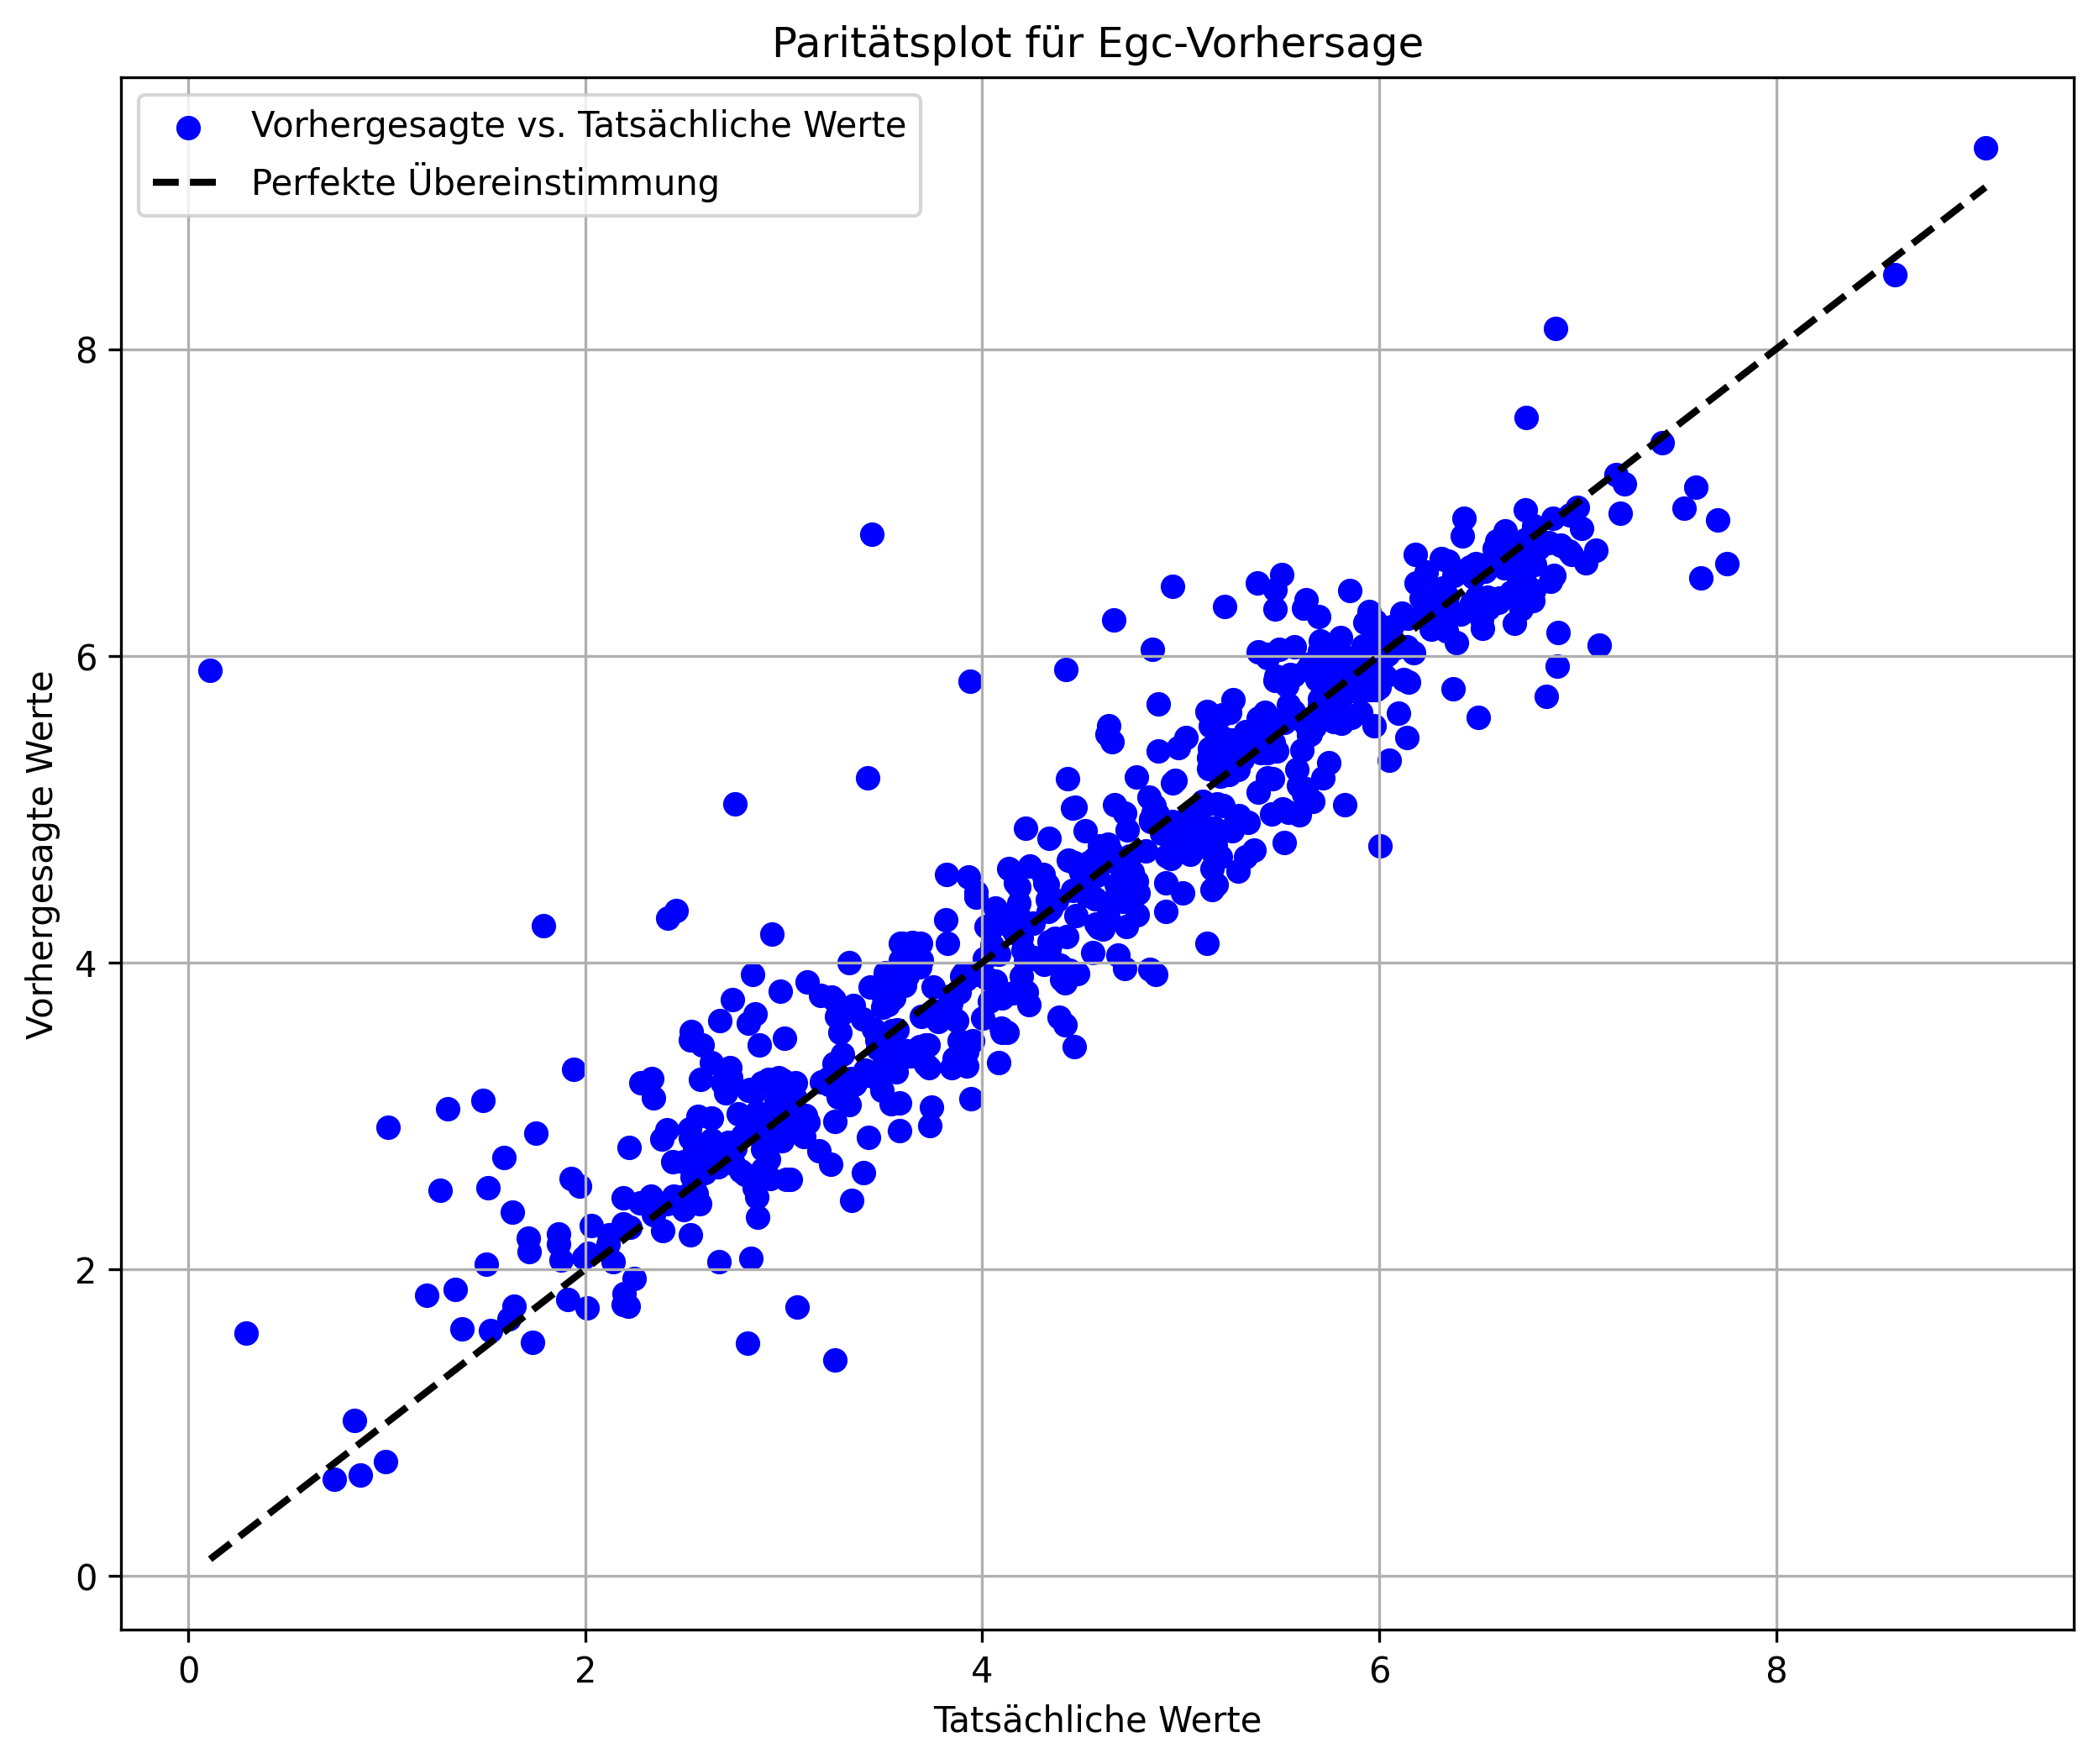

In [49]:
import matplotlib.pyplot as plt

# Vorhersagewerte (angenommen, du hast diese schon)
# y_pred = predictor.predict(test_df.drop(columns=[label]))

# Paritätsplot erstellen
plt.figure(figsize=(6, 4), dpi=300)  # Größe beibehalten, aber Auflösung erhöhen
plt.scatter(y_test, y_pred, color='blue', label='Vorhergesagte vs. Tatsächliche Werte')  # Daten als Punkte darstellen
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfekte Übereinstimmung')  # Linie für perfekte Übereinstimmung
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Paritätsplot für Egc-Vorhersage')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
columns = ['model', 'mean_squared_error', 'mean_absolute_error', 'r2', 'pearsonr', 'median_absolute_error']
df = pd.DataFrame()
model_overview = pd.DataFrame(columns=columns)

for model in models:
    predictor.set_model_best(model)
    evaluation = predictor.evaluate(test_df)
    model_overview.loc[len(df)] = [model, evaluation['mean_squared_error'], evaluation['mean_absolute_error'], evaluation['r2'], evaluation['pearsonr'], evaluation['median_absolute_error']]


Evaluation: root_mean_squared_error on test data: -0.5448502218632079
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.5448502218632079,
    "mean_squared_error": -0.2968617642643868,
    "mean_absolute_error": -0.34747997842512185,
    "r2": 0.8749523577574361,
    "pearsonr": 0.9361762191433102,
    "median_absolute_error": -0.23875393486022944
}
Evaluation: root_mean_squared_error on test data: -0.556867037760214
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.556867037760214,
    "mean_squared_error": -0.31010089774383554,
    "mean_absolute_error": -0.36288456610970243,
    "r2": 0.8693756125304379,
    "pearsonr": 0.9336663088207997,
    "median_absolute_error": -0.2443682004928589
}
Evaluation: root_mean_squared_error on test data: -0.5

In [47]:
print(model_overview)

            model  mean_squared_error  mean_absolute_error        r2  \
0  KNeighborsUnif           -0.632237            -0.515559  0.733682   

   pearsonr  median_absolute_error  
0   0.86599               -0.33689  
